In [1]:
import os, sys
sys.path.append('..')
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.cluster import cluster_trips
from utils.cluster import get_statistics

In [2]:
datadir = os.path.join('..', 'data')
pth = os.path.join(datadir, 'trip_clean.parquet')
df = gpd.read_parquet(pth); df

,medallion,hack_license,pickup,pickup_datetime,vendor_id,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,...,BoroName_pickup_,Shape_Leng_pickup_,Shape_Area_pickup_,dropoff,index_dropoff,BoroCode_dropoff,BoroName_dropoff,Shape_Leng_dropoff,Shape_Area_dropoff,euclidean_distance
0,6EE35E76FB48F9B79A337DDE55381126,16DA2E2A5B7CF561C21886460B636A31,POINT (9.98e+05 2.41e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:04:25,1,206,...,Manhattan,357180.674063,6.363981e+08,POINT (9.96e+05 2.39e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.526704
1,9400FEF51A4DE705BD4578E3AB86A318,A0C7F56B74AB6A80B8B602B8F46262A8,POINT (9.92e+05 2.17e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:05:23,4,310,...,Manhattan,357180.674063,6.363981e+08,POINT (9.96e+05 2.2e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.922924
2,2B131E11C91746501DB1E449ACFDDED5,2C24F168E6F6B8EC4A4D96E575C0EC40,POINT (1.02e+06 2.19e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:15:53,1,911,...,Queens,896934.880411,3.045058e+09,POINT (9.99e+05 2.17e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,4.512526
3,D6B1A78F308FDE278D231C220F83D2A5,931B3AE4A8931DD58BA3E42766889BEC,POINT (9.93e+05 2.17e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:16:43,1,944,...,Manhattan,357180.674063,6.363981e+08,POINT (1.01e+06 2.18e+05),4.0,4.0,Queens,896934.880411,3.045058e+09,2.873268
4,453B4DFA908932D761EF47FE919CDD72,A7B7AAEF95483779C50A7A0551EBD2E4,POINT (9.85e+05 2.01e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:08:29,1,505,...,Manhattan,357180.674063,6.363981e+08,POINT (9.89e+05 2.03e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.952522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526788,FA48B4171DF5DAD8991253F81E2BF0FE,B00DC87B11CCEBDABBF86DD1D6E2CD07,POINT (9.85e+05 2.07e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:58:30,1,74,...,Manhattan,357180.674063,6.363981e+08,POINT (9.85e+05 2.09e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.403466
1526789,1E268C16FEFBC4384CA90B84F8BDD060,1167EF28EEAC54FEDD1DBE1891B1855E,POINT (9.97e+05 2.23e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:59:34,1,130,...,Manhattan,357180.674063,6.363981e+08,POINT (9.96e+05 2.2e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.517157
1526790,68D4B2FDB737B3E4449B8E8FCBEB0CC2,AF905278ACE8A86E989F0B79414571A9,POINT (9.9e+05 2.05e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:59:59,1,138,...,Manhattan,357180.674063,6.363981e+08,POINT (9.89e+05 2.03e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.431326
1526791,D42076D7B45BCFBB8D544D765C2FB094,DC3A15804D7193B647BA71166CF161A8,POINT (9.98e+05 2.25e+05),2013-06-09 23:58:00,CMT,1,N,2013-06-09 23:59:36,1,92,...,Manhattan,357180.674063,6.363981e+08,POINT (1e+06 2.28e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.478341


## Passenger counts per trip

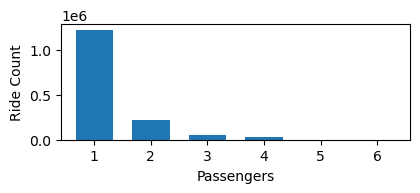

In [3]:
fig, ax = plt.subplots(1, 1, figsize = (4.5, 1.5))
df.passenger_count.value_counts().plot(kind = 'bar', width = .66, ax = ax)
ax.tick_params('x', rotation = 0)
ax.set_xlabel('Passengers')
ax.set_ylabel('Ride Count')
plt.show()

## Hourly pickup trends

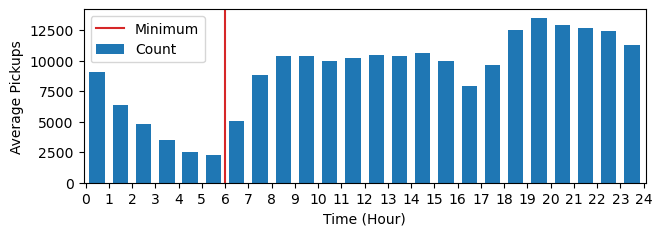

In [4]:
fig, ax = plt.subplots(1, 1, figsize = (7.25, 2.25))
pickup = df.pickup_datetime.dt.hour.value_counts().div(7).sort_index()
pickup.plot(kind = 'bar', width = .66, label = 'Count', ax = ax)
ax.axvline(pickup.idxmin() + .5, c = 'tab:red', label = 'Minimum')
xticks = np.arange(25)
ax.set_xticks(xticks - .5, xticks, rotation = 0)
ax.set_xlabel('Time (Hour)')
ax.set_ylabel('Average Pickups')
ax.legend()
plt.show()

## Cluster trips using HDBSCAN
- Input: (x,y) values for pickup/dropoff + scaled t (pickup only)
- Output: cluster labels per trip/passenger
- Windows: $\leq$ 24 hrs (split = 6 AM)

## Explore spatiotemporal tradeoff

In [5]:
sample_frac = .3
minutes_per_mile = np.arange(2, 31, 2)        # spatiotemporal knob
stats = np.zeros((minutes_per_mile.size, 7))  # summary statistics
for i in range(minutes_per_mile.size):
    print('\n', minutes_per_mile[i], 'minute(s) / mile')
    df_i = cluster_trips(df, minutes_per_mile[i],
        sample_frac = sample_frac, verbose = True)
    stats[i] = get_statistics(df_i)


 2 minute(s) / mile
0 2013-06-03 00:00:00 2013-06-03 05:59:00
1 2013-06-03 06:00:00 2013-06-04 05:59:00
2 2013-06-04 06:00:00 2013-06-05 05:59:00
3 2013-06-05 06:00:00 2013-06-06 05:59:00
4 2013-06-06 06:00:00 2013-06-07 05:59:00
5 2013-06-07 06:00:00 2013-06-08 05:59:00
6 2013-06-08 06:00:00 2013-06-09 05:59:00
7 2013-06-09 06:00:00 2013-06-09 23:58:00

 4 minute(s) / mile
0 2013-06-03 00:00:00 2013-06-03 05:59:00
1 2013-06-03 06:00:00 2013-06-04 05:59:00
2 2013-06-04 06:00:00 2013-06-05 05:59:00
3 2013-06-05 06:00:00 2013-06-06 05:59:00
4 2013-06-06 06:00:00 2013-06-07 05:59:00
5 2013-06-07 06:00:00 2013-06-08 05:59:00
6 2013-06-08 06:00:00 2013-06-09 05:59:00
7 2013-06-09 06:00:00 2013-06-09 23:58:00

 6 minute(s) / mile
0 2013-06-03 00:00:00 2013-06-03 05:59:00
1 2013-06-03 06:00:00 2013-06-04 05:59:00
2 2013-06-04 06:00:00 2013-06-05 05:59:00
3 2013-06-05 06:00:00 2013-06-06 05:59:00
4 2013-06-06 06:00:00 2013-06-07 05:59:00
5 2013-06-07 06:00:00 2013-06-08 05:59:00
6 2013-06-08 

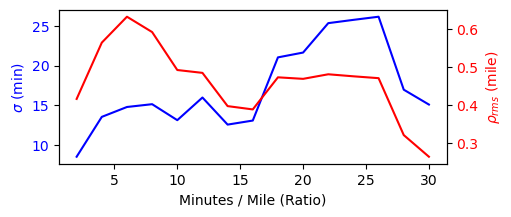

In [ ]:
# moving average (10 min / 5 steps)
sm = 10 // 2; v = np.ones(sm) / sm
stats_sm = stats.copy()
for i in range(stats_sm.shape[1]):
    stats_sm[:, i] = np.convolve(stats_sm[:, i], v, mode = 'same')

# summary statistics
_, _, _, rms_pickup_loc, rms_dropoff_loc, std_pickup_t, std_dropoff_t = stats_sm.T
rms_loc = (rms_pickup_loc + rms_dropoff_loc) / 2
std_t = (std_pickup_t + std_dropoff_t) / 2

# Std of pickup/dropoff times (mean)
fig, ax = plt.subplots(1, 1, figsize = (5, 2))
ax.plot(minutes_per_mile, std_t, c = 'b')
ax.set_ylabel(r'$\sigma$ (min)', color = 'b')
ax.tick_params('y', labelcolor = 'b')

# RMS of pickup locations (mean)
ax0 = ax.twinx()
ax0.plot(minutes_per_mile, rms_loc, c = 'r')
ax0.set_ylabel(r'$\rho_{rms}$ (mile)', color = 'r')
ax0.tick_params('y', labelcolor = 'r')
ax.set_xlabel('Minutes / Mile (Ratio)')
plt.show()

## Final iterative HDBSCAN clustering

In [5]:
van_size = 6   # decrease each iteration
minutes_per_mile = 15
max_clus_size = 120
df_clus = df.copy()
df_clus['cluster_label'] = -1
for i in range(van_size - 1):
    # select unclustered trips/passengers
    clus_count = df_clus.groupby('cluster_label').passenger_count.sum()
    clus_i = clus_count.index[clus_count > max_clus_size]
    df_i = df_clus.loc[df_clus.cluster_label.isin(clus_i)]

    # cluster selected trips/passengers
    print('\nIteration', i, '— van_size =', van_size, 'and n =', df_i.shape[0])
    df_i = cluster_trips(df_i, minutes_per_mile, van_size, verbose = True)
    labels = df_i['cluster_label'].copy()
    labels[labels > -1] += df_clus.cluster_label.max() + 1
    df_clus.loc[df_i.index, 'cluster_label'] = labels
    van_size -= 1


Iteration 0 — van_size = 6 and n = 1526793
0 2013-06-03 00:00:00 2013-06-03 05:59:00
1 2013-06-03 06:00:00 2013-06-04 05:59:00
2 2013-06-04 06:00:00 2013-06-05 05:59:00
3 2013-06-05 06:00:00 2013-06-06 05:59:00
4 2013-06-06 06:00:00 2013-06-07 05:59:00
5 2013-06-07 06:00:00 2013-06-08 05:59:00
6 2013-06-08 06:00:00 2013-06-09 05:59:00
7 2013-06-09 06:00:00 2013-06-09 23:58:00

Iteration 1 — van_size = 5 and n = 1349075
0 2013-06-03 00:00:00 2013-06-03 05:59:00
1 2013-06-03 06:00:00 2013-06-04 05:59:00
2 2013-06-04 06:00:00 2013-06-05 05:59:00
3 2013-06-05 06:00:00 2013-06-06 05:59:00
4 2013-06-06 06:00:00 2013-06-07 05:59:00
5 2013-06-07 06:00:00 2013-06-08 05:59:00
6 2013-06-08 06:00:00 2013-06-09 05:59:00
7 2013-06-09 06:00:00 2013-06-09 23:58:00

Iteration 2 — van_size = 4 and n = 1099618
0 2013-06-03 00:00:00 2013-06-03 05:59:00
1 2013-06-03 06:00:00 2013-06-04 05:59:00
2 2013-06-04 06:00:00 2013-06-05 05:59:00
3 2013-06-05 06:00:00 2013-06-06 05:59:00
4 2013-06-06 06:00:00 2013-0

In [6]:
df_clus

,medallion,hack_license,pickup,pickup_datetime,vendor_id,rate_code,store_and_fwd_flag,dropoff_datetime,passenger_count,trip_time_in_secs,...,Shape_Leng_pickup_,Shape_Area_pickup_,dropoff,index_dropoff,BoroCode_dropoff,BoroName_dropoff,Shape_Leng_dropoff,Shape_Area_dropoff,euclidean_distance,cluster_label
0,6EE35E76FB48F9B79A337DDE55381126,16DA2E2A5B7CF561C21886460B636A31,POINT (9.98e+05 2.41e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:04:25,1,206,...,357180.674063,6.363981e+08,POINT (9.96e+05 2.39e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.526704,103043
1,9400FEF51A4DE705BD4578E3AB86A318,A0C7F56B74AB6A80B8B602B8F46262A8,POINT (9.92e+05 2.17e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:05:23,4,310,...,357180.674063,6.363981e+08,POINT (9.96e+05 2.2e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.922924,22615
2,2B131E11C91746501DB1E449ACFDDED5,2C24F168E6F6B8EC4A4D96E575C0EC40,POINT (1.02e+06 2.19e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:15:53,1,911,...,896934.880411,3.045058e+09,POINT (9.99e+05 2.17e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,4.512526,-1
3,D6B1A78F308FDE278D231C220F83D2A5,931B3AE4A8931DD58BA3E42766889BEC,POINT (9.93e+05 2.17e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:16:43,1,944,...,357180.674063,6.363981e+08,POINT (1.01e+06 2.18e+05),4.0,4.0,Queens,896934.880411,3.045058e+09,2.873268,163292
4,453B4DFA908932D761EF47FE919CDD72,A7B7AAEF95483779C50A7A0551EBD2E4,POINT (9.85e+05 2.01e+05),2013-06-03 00:00:00,CMT,1,N,2013-06-03 00:08:29,1,505,...,357180.674063,6.363981e+08,POINT (9.89e+05 2.03e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.952522,103649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1526788,FA48B4171DF5DAD8991253F81E2BF0FE,B00DC87B11CCEBDABBF86DD1D6E2CD07,POINT (9.85e+05 2.07e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:58:30,1,74,...,357180.674063,6.363981e+08,POINT (9.85e+05 2.09e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.403466,247546
1526789,1E268C16FEFBC4384CA90B84F8BDD060,1167EF28EEAC54FEDD1DBE1891B1855E,POINT (9.97e+05 2.23e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:59:34,1,130,...,357180.674063,6.363981e+08,POINT (9.96e+05 2.2e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.517157,159079
1526790,68D4B2FDB737B3E4449B8E8FCBEB0CC2,AF905278ACE8A86E989F0B79414571A9,POINT (9.9e+05 2.05e+05),2013-06-09 23:57:00,CMT,1,N,2013-06-09 23:59:59,1,138,...,357180.674063,6.363981e+08,POINT (9.89e+05 2.03e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.431326,-1
1526791,D42076D7B45BCFBB8D544D765C2FB094,DC3A15804D7193B647BA71166CF161A8,POINT (9.98e+05 2.25e+05),2013-06-09 23:58:00,CMT,1,N,2013-06-09 23:59:36,1,92,...,357180.674063,6.363981e+08,POINT (1e+06 2.28e+05),3.0,1.0,Manhattan,357180.674063,6.363981e+08,0.478341,-1


In [7]:
frac_clus, clus_size_mean, clus_size_max, rms_pickup_loc, \
 rms_dropoff_loc, std_pickup_t, std_dropoff_t = get_statistics(df_clus)

print('passengers clustered (fraction) =', frac_clus)
print('passengers per cluster (mean) =', clus_size_mean)
print('largest cluster (passengers) =', clus_size_max)
print('RMS of pickup locations [miles] (mean) = ', rms_pickup_loc)
print('RMS of dropoff locations [miles] (mean) =', rms_dropoff_loc)
print('Std of pickup times [minutes] (mean) =', std_pickup_t)
print('Std of dropoff times [minutes] (mean) =', std_dropoff_t)

passengers clustered (fraction) = 0.8425415285886309
passengers per cluster (mean) = 6.551633340248632
largest cluster (passengers) = 120
RMS of pickup locations [miles] (mean) =  0.21953108743032557
RMS of dropoff locations [miles] (mean) = 0.230876909943041
Std of pickup times [minutes] (mean) = 3.491909807542268
Std of dropoff times [minutes] (mean) = 4.9277030590236155


In [8]:
df_clus.to_parquet(os.path.join(datadir, 'trip_cluster.parquet'))